# DeepDream

We'll describe an implementation of DeepDream.

## Load Data

We'll load the example image of the Drosophila ssTEM dataset from https://figshare.com/articles/dataset/Segmented_anisotropic_ssTEM_dataset_of_neural_tissue/856713. Alternatively, you can download an image from the corresponding GiHub repository: http://github.com/unidesigner/groundtruth-drosophila-vnc.

In [1]:
from PIL import Image

im = Image.open("neuraltissue_with_colorlabels.png").convert('RGB').resize((256, 256))

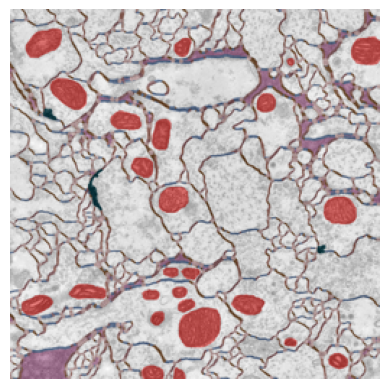

In [2]:
import matplotlib.pyplot as plt

plt.imshow(im)
plt.axis('off')
plt.show()

We download a pretrained model (VGG16), with the weigths ... and freeze all the weights.

In [3]:
import torchvision.models as models
from torchvision.models import VGG16_Weights

model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

model.eval()
model.requires_grad_(False)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

The VGG16 is pretrained on the ImageNet dataset and the inputs are normalized wih respect to the mean and standard deviation of the channels of this dataset.

We'll define a function that perform loss maximization through gradient ascend. 

In [5]:
import numpy as np
import torch
import torchvision.transforms as tt
from PIL import Image
from fnc_deepdream import fwd_hooks

def deepdream(im, layers, iter_num=100, step=.01):
    # Normalization parameters typically used with pretrained models
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    # Define bounds for normalized image values
    low = torch.tensor((-mean / std).reshape(1, -1, 1, 1))
    high = torch.tensor(((1 - mean) / std).reshape(1, -1, 1, 1))

    # Preprocess the image: convert to tensor and normalize
    normalize = tt.Compose([tt.ToTensor(), tt.Normalize(mean, std)])
    image = normalize(im).unsqueeze(0).requires_grad_(True)
    
    # Perform DeepDream iterations
    for _ in range(iter_num):
        # Forward pass through the model and collect specified layer activations
        with fwd_hooks(layers) as fh:  # fwd_hooks not defined in this snippet
            _ = model(image)  # model not defined in this snippet

        # Calculate mean activation for each layer and sum them as total loss
        losses = [activation.mean() for activation in fh.activations]
        loss = torch.stack(losses).sum()
        loss.backward()

        # Update the image by gradient ascent and normalize the gradient
        image.data += step * ((image.grad.data - torch.mean(image.grad.data)) 
                              / (torch.std(image.grad.data) + 1e-8))
        image.grad.data.zero_()  # Clear gradients for next iteration

        # Clamp the image data to ensure pixel values are valid
        image.data.clamp_(low, high)

    # Postprocess: Convert back to image format
    denormalize = tt.Normalize(mean=-mean / std, std=1 / std)
    im_array = denormalize(image.data.clone().detach().squeeze()).numpy()
    im_array = np.clip(im_array.transpose(1, 2, 0) * 255, 0, 255).astype(np.uint8)
    return Image.fromarray(im_array, 'RGB')

We'll apply deepdreams to the image, using as output the activations of the first ReLU.

In [6]:
layers = [model.features[1]]

im_out_1 = deepdream(im, layers, iter_num=100, step=.01)

Plot DeepDream

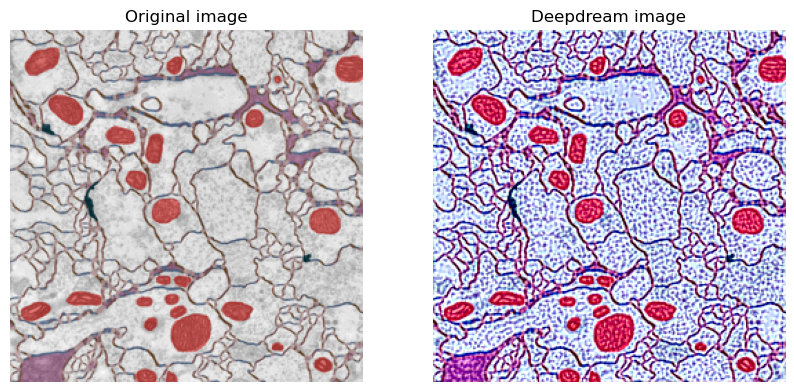

In [8]:
from fnc_deepdream import plot_deepdream

plot_deepdream(im, im_out_1)

By using deeper layer activations, we'll enhance features at larger scales. 

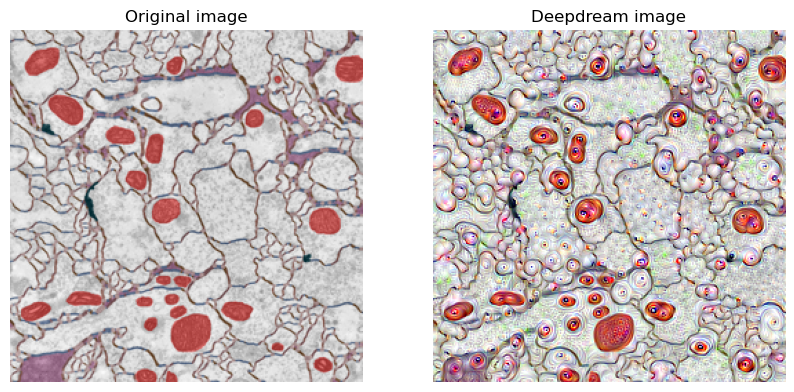

In [9]:
layers = [model.features[18]]

im_out_18 = deepdream(im, layers, iter_num=100, step=.01)

plot_deepdream(im, im_out_18)

We'll combine images at different resolutions using octaves. (This can take a few minutes to complete).

a technique often used in the DeepDream algorithm, which involves processing the image at multiple scales or "octaves". This technique is used to enhance the effects of the DeepDream algorithm by capturing and emphasizing patterns at different levels of granularity. 

Iterative process!

In [10]:
octave_scale=1.4

# Initialize the image for octave processing
original_size = im.size
processed_image = im

# Define the layer to be used by DeepDream
layers = [model.features[18]]

# Iterate over the range of octaves
for octave in range(-2, 3):
    # Resize the image for the current octave
    new_size = (
        int(original_size[0] * (octave_scale ** octave)), 
        int(original_size[1] * (octave_scale ** octave)),
    )
    resized_image = processed_image.resize(new_size, Image.LANCZOS)

    # Apply DeepDream to the resized image
    deepdreamed_image = deepdream(resized_image, layers, 
                                  iter_num=100, step=.01)

    # Resize the processed image back to the original size
    processed_image = deepdreamed_image.resize(original_size, Image.LANCZOS)

plot_deepdream(im, processed_image)

We can furthermore use the output of several layers simultaneously to enhance multiple features. (This can take a few minutes to complete).

In [ ]:
octave_scale=1.4

# Initialize the image for octave processing
original_size = im.size
processed_image = im

# Define indices of layers to be used in DeepDream
layer_indices = [15, 18, 20, 22, 25, 27, 29]
layers = [model.features[i] for i in layer_indices]

# Iterate over the range of octaves
for octave in range(-2, 3):
    # Resize the image for the current octave
    new_size = (
        int(original_size[0] * (octave_scale ** octave)), 
        int(original_size[1] * (octave_scale ** octave)),
    )
    resized_image = processed_image.resize(new_size, Image.LANCZOS)

    # Apply DeepDream to the resized image
    deepdreamed_image = deepdream(resized_image, layers, 
                                  iter_num=200, step=.01)

    # Resize the processed image back to the original size
    processed_image = deepdreamed_image.resize(original_size, Image.LANCZOS)

plot_deepdream(im, processed_image)